In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

### prepare dataset
- feature_paths: features in numpy file format
- captions: each feature has 5 captions

In [2]:
import os
import json
import pandas as pd

In [3]:
json_label = os.listdir('captioning_annotation')
json_label = [os.path.join('captioning_annotation', f) for f in json_label]
json_label

['captioning_annotation\\captions_train2014.json',
 'captioning_annotation\\captions_val2014.json']

In [4]:
def load_jsonfile(jsonfile):
    ''' load json file '''
    with open(jsonfile) as json_data:
        data = json.load(json_data)
    return data
# Useful keys in data['images']: 'file_name', 'id'
# Useful keys in data['annotations']: 'image_id', 'id', 'caption'
# Note: 'id' in data['images'] matches to 'image_id' in data['annotations']
def generate_dataframe(data, main_key, sub_keys):
    ''' load json data into pandas dataframe
        - inputs:
            - data: json data
            - main_key
            - sub_keys
        - return:
            - df: pandas dataframe,
                the columns are sub_keys
    '''
    D = data[main_key]
    df = pd.DataFrame()
    for key in sub_keys:
        temp = []
        for d in D:
            temp.append(d[key])
        df[key] = temp
    return df
#
data = load_jsonfile(json_label[0])
df1 = generate_dataframe(data, 'images', ['file_name', 'id'])
df1 = df1.rename(columns = {'id': 'image_id'}).sort_values('image_id').reset_index(drop=True)
#
df2 = generate_dataframe(data, 'annotations', ['image_id', 'id', 'caption']).sort_values('image_id').reset_index(drop=True)
#
df = pd.merge(df1, df2, how='inner', on='image_id')

In [5]:
feature_paths = df['file_name'].values.tolist()
feature_paths = [f.split('.')[0]+'.npy' for f in feature_paths]
feature_paths = [os.path.join('train_inceptionv3_feature', f) for f in feature_paths]
captions = '<start> ' + df['caption'] + ' <end>'

In [6]:
captions = captions.values.tolist()

### Cutdown training data

In [7]:
n = 250000
feature_paths = feature_paths[0:n]
captions = captions[0:n]

### tokenizer captions
- feature_paths
- seqs

In [8]:
top_k = 8000

In [9]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token='<unk>',
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(captions)

In [10]:
seqs = tokenizer.texts_to_sequences(captions)
seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs,
                                                     maxlen=40,
                                                     padding='post',
                                                     truncating='post')

In [11]:
tokenizer.index_word[0] = '<pad>'
tokenizer.word_index['<pad>'] = 0

In [12]:
len(tokenizer.word_index)

19387

### tensorflow dataset input pipeline

In [12]:
def map_func(path, seq):
    
    img_tensor = np.load(path.decode('utf-8'))
    
    return img_tensor, seq

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((feature_paths, seqs))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(1000).batch(64)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# start = time.time()
# for a, b in dataset:
#     pass
# end = time.time() - start
# print(f'{end} seconds')

### build attention mechanism

In [14]:
class Attention(tf.keras.Model):
    ''' How to use attention
        In call func:
            - inputs:
                    - features: (from the output of encoder) 
                    - state: (from the hidden state of decoder)
            - return:
                    - context_vector: need to be pass into decoder
                    - attn_weights: use for visualization on the image,
                                    you can see which part of the image
                                    contributes to a specific word
    '''
    
    def __init__(self, units):
        super(Attention, self).__init__()
        # for image features
        self.W1 = tf.keras.layers.Dense(units)
        # for decoder hidden state
        self.W2 = tf.keras.layers.Dense(units)
        # for attention score
        self.V  = tf.keras.layers.Dense(1)
        
    def call(self, features, state):
        # original features (bs,64,2048) are encoded by Encoder
        # so features: (bs, 64, units)
        
        # state: (bs, 1, units in the decoder)
        state = tf.expand_dims(state, 1)
        
        # attn_scores: (bs, 64, units)
        attn_scores  = tf.nn.tanh(self.W1(features) + self.W2(state))
        
        # self.V(): (bs, 64, 1)
        # attn_weights: (bs, 64, 1)
        attn_weights = tf.nn.softmax(self.V(attn_scores), axis=1)
        
        # context_vector: (bs, 64, units)
        context_vector = attn_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attn_weights

In [ ]:
attention = Attention(256)

In [ ]:
features = tf.ones((16, 64, 256))
state = tf.ones((16, 256))

In [ ]:
cv, attn_weight = attention(features, state)

In [ ]:
cv.shape, attn_weight.shape

### build encoder

In [15]:
class Encoder(tf.keras.Model):
    
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
    
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### build decoder

In [16]:
class Decoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, units):
        super(Decoder, self).__init__()
        # use for decoder gru
        self.units = units
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.attention = Attention(self.units)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x, features, state):
        # input x: (bs, 1)
        # encoded word x: (bs, 1, embedding_dim)
        x = self.embedding(x)
        
        # context_vector: (bs, 256)
        # attn_weights: (bs, 64, 1)
        context_vector, attn_weights = self.attention(features, state)
        
        # combine encoded word and context_vector
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # pass x into GRU
        output, state = self.gru(x)
        
        x = self.fc1(output)
        
        x = tf.reshape(x, (-1, x.shape[2]))
        
        x = self.fc2(x)
        
        return x, state, attn_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [17]:
embedding_dim = 512
units = 256
vocab_size = top_k + 1
vocab_size

8001

In [18]:
encoder = Encoder(embedding_dim)
decoder = Decoder(vocab_size, embedding_dim, units)

### loss function

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_func(real, pred):
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, tf.float32)
    loss_ = loss_object(real, pred)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

### checkpoint

In [20]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [21]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

### train_step function

In [22]:
BATCH_SIZE = 64

In [23]:
@tf.function
def train_step(image_tensor, target):
    
    loss = 0
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']]*target.shape[0], 1)
    state = decoder.reset_state(target.shape[0])
    
    with tf.GradientTape() as tape:
        features = encoder(image_tensor)
        
        for i in range(1, target.shape[1]):
            prediction, state, _ = decoder(dec_input, features, state)
            
            loss += loss_func(target[:, i], prediction)
            
            dec_input = tf.expand_dims(target[:, i], 1)
            
    total_loss = (loss/int(target.shape[1]))
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradient = tape.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradient, trainable_variables))
    
    return loss, total_loss

### train

In [24]:
num_steps = len(captions)//BATCH_SIZE
loss_plot = []

In [25]:
Epochs = 10

for epoch in range(start_epoch, Epochs):
    
    start = time.time()
    
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {}/{} Loss {:.4f}'.format(epoch+1, batch, num_steps,
                                                            batch_loss.numpy()/int(target.shape[1])))
    loss_plot.append(total_loss/num_steps)
    ckpt_manager.save()
    print('Checkpoint Saved --------------- AHAHA')
    print('Epoch {} Loss {:.6f}'.format(epoch+1, total_loss/num_steps))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0/3906 Loss 2.5463
Epoch 1 Batch 100/3906 Loss 1.5522
Epoch 1 Batch 200/3906 Loss 1.4995
Epoch 1 Batch 300/3906 Loss 1.4637
Epoch 1 Batch 400/3906 Loss 1.5702
Epoch 1 Batch 500/3906 Loss 1.4922
Epoch 1 Batch 600/3906 Loss 1.3053
Epoch 1 Batch 700/3906 Loss 1.0854
Epoch 1 Batch 800/3906 Loss 1.0551
Epoch 1 Batch 900/3906 Loss 1.0622
Epoch 1 Batch 1000/3906 Loss 1.0754
Epoch 1 Batch 1100/3906 Loss 1.0183
Epoch 1 Batch 1200/3906 Loss 0.9382
Epoch 1 Batch 1300/3906 Loss 0.9747
Epoch 1 Batch 1400/3906 Loss 0.9061
Epoch 1 Batch 1500/3906 Loss 0.8778
Epoch 1 Batch 1600/3906 Loss 0.9051
Epoch 1 Batch 1700/3906 Loss 0.9763
Epoch 1 Batch 1800/3906 Loss 0.9465
Epoch 1 Batch 1900/3906 Loss 0.8530
Epoch 1 Batch 2000/3906 Loss 0.9834
Epoch 1 Batch 2100/3906 Loss 0.8337
Epoch 1 Batch 2200/3906 Loss 0.9537
Epoch 1 Batch 2300/3906 Loss 0.8769
Epoch 1 Batch 2400/3906 Loss 0.8260
Epoch 1 Batch 2500/3906 Loss 0.8104
Epoch 1 Batch 2600/3906 Loss 0.8597
Epoch 1 Batch 2700/3906 Loss 0.8249
Epoc

### test data

In [125]:
new_jpegs = os.listdir('new_images')
new_jpegs = [os.path.join('new_images', f) for f in new_jpegs]

In [40]:
def load_inceptionv3():
    
    pretrained = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                                                                weights='imagenet')
    feature_extractor = tf.keras.Model(pretrained.input,
                                       pretrained.layers[-1].output)
    return feature_extractor

fea_ext = load_inceptionv3()

In [68]:
def preprocess_image(jpeg_path):
    img = tf.io.read_file(jpeg_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img_tensor = tf.keras.applications.inception_v3.preprocess_input(img)
    img_tensor = fea_ext(img_tensor[tf.newaxis, ...])
    return img_tensor, img

In [193]:
def gencap(jpeg_path):
    
    Cap = []
    Attn = []
    
    feature, img = preprocess_image(jpeg_path)
    feature = encoder(feature)
    feature = tf.reshape(feature, (1, -1, feature.shape[-1]))
    
    state = decoder.reset_state(batch_size=1)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1)
    
    for i in range(40):
        pred, state, attn = decoder(dec_input, feature, state)
        pred = tf.argmax(pred, -1).numpy()[0]
        
        if tokenizer.index_word[pred] == '<end>':
            return Cap, Attn, img.numpy().astype(np.uint8)
        
        Cap.append(tokenizer.index_word[pred])
        Attn.append(attn.numpy())
        dec_input = tf.expand_dims([pred], 1)
        
    return Cap, Attn, img.numpy().astype(np.uint8)

def plot_attn_maps(caption, attn, image):
    
    lens = len(caption)
    rows = 2
    cols = lens//rows+1
    fig = plt.figure(figsize=(15, 6))
    
    for i in range(lens):
        ax = fig.add_subplot(rows, cols, i+1)
        img = ax.imshow(image)
        ax.imshow(np.resize(attn[i], (8, 8)),
                  cmap='gray',
                  alpha=0.5,
                  extent=img.get_extent())
        ax.set_title(caption[i], fontsize=20)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

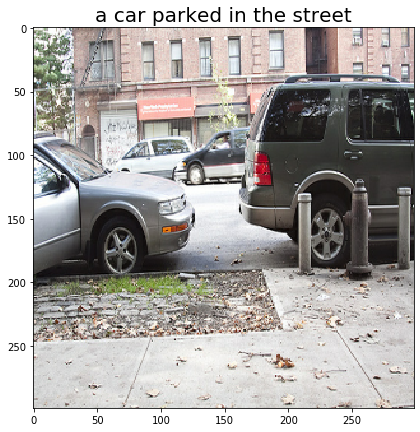

In [203]:
C, A, img = gencap(new_jpegs[15])
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.title(' '.join(C), fontsize=20)
plt.show()

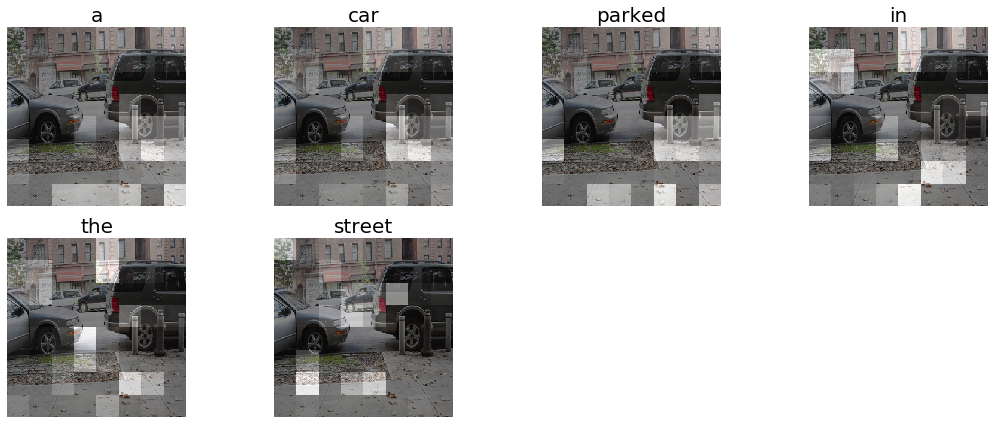

In [204]:
plot_attn_maps(C, A, img)

### save model by pickle

In [205]:
import pickle

In [212]:
def pickle_obj(module, name):
    save_to = 'imgcap_model'
    pickle_out = open(os.path.join(save_to, name+'.pickle'), 'wb')
    pickle.dump(module, pickle_out)
    pickle_out.close()
    print('saved name')

In [215]:
pickle_obj(tokenizer, 'tokenizer')

saved name


In [220]:
encoder.save_weights(os.path.join('imgcap_model', 'encoder_weights'))

In [221]:
decoder.save_weights(os.path.join('imgcap_model', 'decoder_weights'))